In [127]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import os

os.makedirs('plots', exist_ok=True)

plt.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "font.size": 11,
    "legend.fontsize": 9,
})

df = pd.read_csv(r'c:\Users\patri\Downloads\sim_parameters_historical_combined.csv')

# Wind direction vector averaging functions

def average_direction(degree_list):
    """Calculate the average direction in degrees"""
    sin_sum = sum(math.sin(math.radians(d)) for d in degree_list)
    cos_sum = sum(math.cos(math.radians(d)) for d in degree_list)
    sin_avg = sin_sum / len(degree_list)
    cos_avg = cos_sum / len(degree_list)
    avg_angle = math.degrees(math.atan2(sin_avg, cos_avg))
    return avg_angle % 360

def wind_vector_by_altitude(df, altitude):
    """Returns (avg_direction, avg_speed) for a given altitude"""
    direction_col = f'direction [{altitude}]'
    speed = str(altitude)
    
    avg_direction = average_direction(df[direction_col].tolist())
    avg_speed = df[speed].mean()

    return (avg_direction, avg_speed)

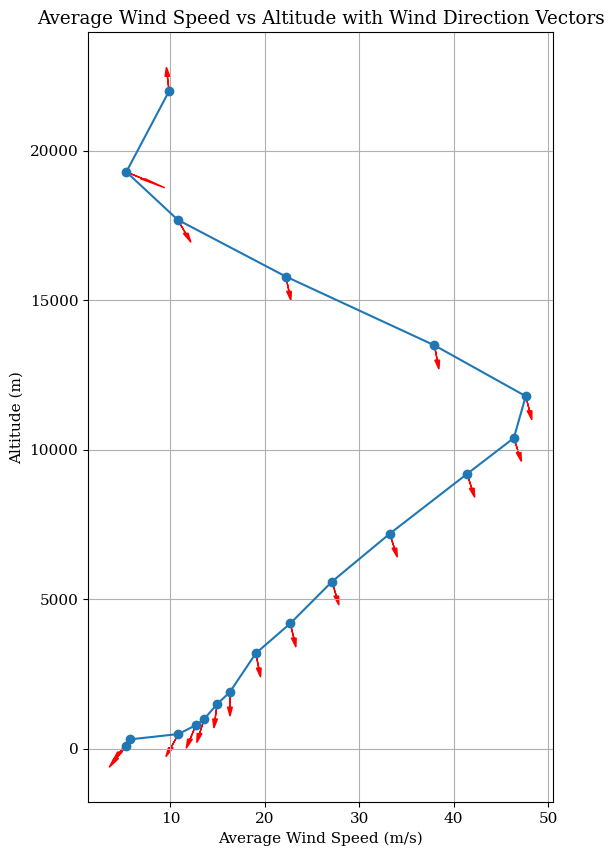

In [128]:
df['hour'] = pd.to_datetime(df['date'], format ='mixed').dt.hour
df['date_only'] = pd.to_datetime(df['date'], format ='mixed').dt.date
wind_speed_cols = [col for col in df.columns if 'stdev' not in col and 'direction' not in col and col not in ['date', 'temperature', 'pressure', 'hour', 'date_only']]
avg_wind_speeds = df[wind_speed_cols].mean()
altitudes = [int(col) for col in wind_speed_cols]

# Plot avg wind speed vs altitude with direction vectors

plt.figure(figsize=(6,10))
plt.plot(avg_wind_speeds, altitudes, marker='o')
arrow_scale_x = 2
arrow_scale_y = 500

for i, alt in enumerate(altitudes):
    speed = avg_wind_speeds.iloc[i]
    direction, _ = wind_vector_by_altitude(df, alt)

    arrow_x = math.cos(math.radians(direction)) * arrow_scale_x
    arrow_y = math.sin(math.radians(direction)) * arrow_scale_y

    plt.arrow(speed, alt, arrow_x, arrow_y, head_width=0.5, head_length=300, fc='red', ec='red')

plt.xlabel('Average Wind Speed (m/s)')
plt.ylabel('Altitude (m)')
plt.title('Average Wind Speed vs Altitude with Wind Direction Vectors')
plt.grid(True)
plt.savefig('plots/average_wind_speed_vs_altitude.png', dpi=300, bbox_inches='tight')
plt.show()

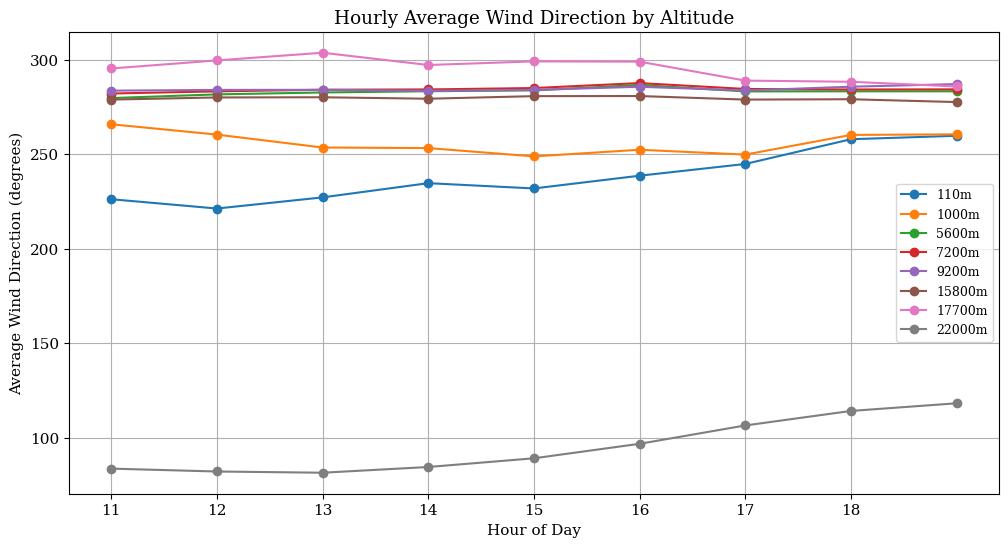

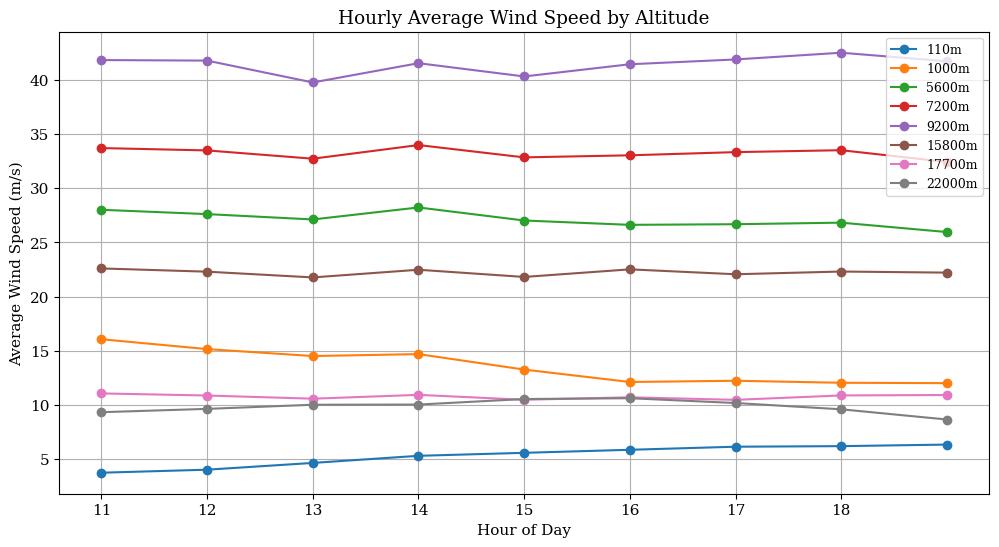

In [129]:
# Plot avg wind direction at different altitudes by hour of day

altitudes = [110, 1000, 5600, 7200, 9200, 15800, 17700, 22000]

plt.figure(figsize=(12,6))

for alt in altitudes:

    direction_col = f'direction [{alt}]'

    avg_direction_by_hour = df.groupby('hour')[direction_col].apply(lambda dirs: average_direction(dirs.tolist()))
    
    plt.plot(avg_direction_by_hour.index, avg_direction_by_hour.values, marker='o', label=f'{alt}m')

plt.xlabel('Hour of Day')
plt.ylabel('Average Wind Direction (degrees)')
plt.title('Hourly Average Wind Direction by Altitude')
plt.xticks(range(11, 19))
plt.legend()
plt.grid(True)
plt.savefig('plots/hourly_average_wind_direction_by_altitude.png', dpi=300, bbox_inches='tight')
plt.show()


# Plot avg wind speed at different altitudes by hour of day

altitudes = [110, 1000, 5600, 7200, 9200, 15800, 17700, 22000]

plt.figure(figsize=(12, 6))

for alt in altitudes:
    speed_col = str(alt)
    
    avg_speed_by_hour = df.groupby('hour')[speed_col].mean()
    
    plt.plot(avg_speed_by_hour.index, avg_speed_by_hour.values, marker='o', label=f'{alt}m')

plt.xlabel('Hour of Day')
plt.ylabel('Average Wind Speed (m/s)')
plt.title('Hourly Average Wind Speed by Altitude')
plt.xticks(range(11, 19))
plt.legend()
plt.grid(True)
plt.savefig('plots/hourly_average_wind_speed_by_altitude.png', dpi=300, bbox_inches='tight')
plt.show()

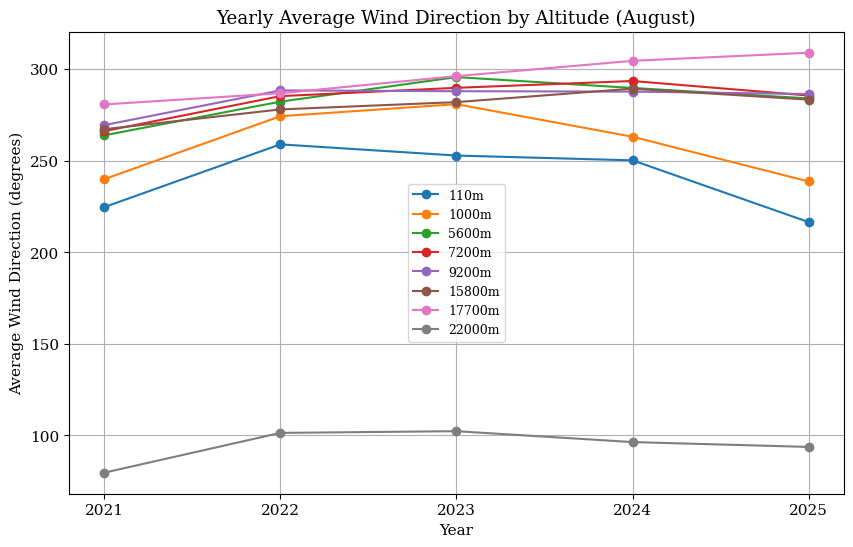

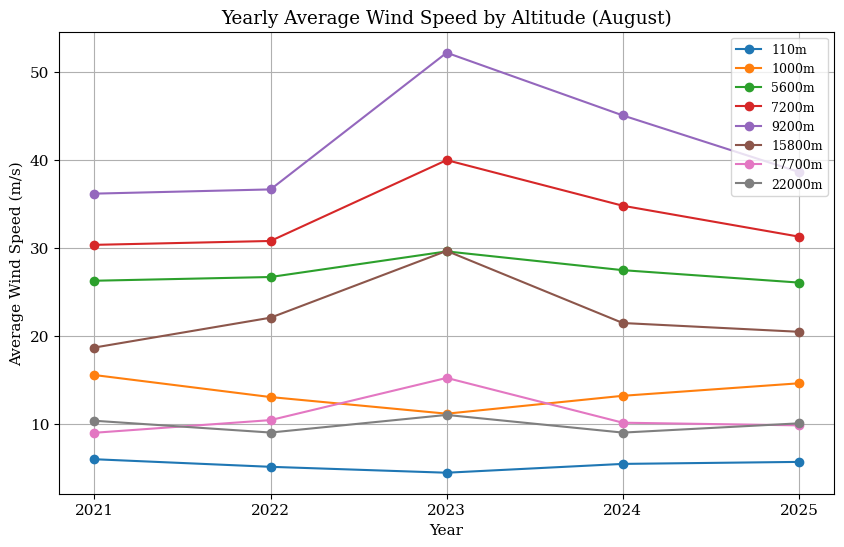

In [130]:
# Plot avg wind direction at different altitudes by year

df['year'] = pd.to_datetime(df['date'], format='mixed').dt.year

altitudes = [110, 1000, 5600, 7200, 9200, 15800, 17700, 22000]

plt.figure(figsize=(10, 6))

for alt in altitudes:
    direction_col = f'direction [{alt}]'
    avg_direction_by_year = df.groupby('year')[direction_col].apply(lambda dirs: average_direction(dirs.tolist()))
    plt.plot(avg_direction_by_year.index, avg_direction_by_year.values, marker='o', label=f'{alt}m')

plt.xlabel('Year')
plt.ylabel('Average Wind Direction (degrees)')
plt.title('Yearly Average Wind Direction by Altitude (August)')
plt.xticks([2021, 2022, 2023, 2024, 2025])
plt.legend()
plt.grid(True)
plt.savefig('plots/yearly_average_wind_direction_by_altitude.png', dpi=300, bbox_inches='tight')
plt.show()


# Plot avg wind speed at different altitudes by year

altitudes = [110, 1000, 5600, 7200, 9200, 15800, 17700, 22000]

plt.figure(figsize=(10, 6))

for alt in altitudes:
    speed_col = str(alt)
    avg_speed_by_year = df.groupby('year')[speed_col].mean()
    plt.plot(avg_speed_by_year.index, avg_speed_by_year.values, marker='o', label=f'{alt}m')

plt.xlabel('Year')
plt.ylabel('Average Wind Speed (m/s)')
plt.title('Yearly Average Wind Speed by Altitude (August)')
plt.xticks([2021, 2022, 2023, 2024, 2025])
plt.legend()
plt.grid(True)
plt.savefig('plots/yearly_average_wind_speed_by_altitude.png', dpi=300, bbox_inches='tight')
plt.show()

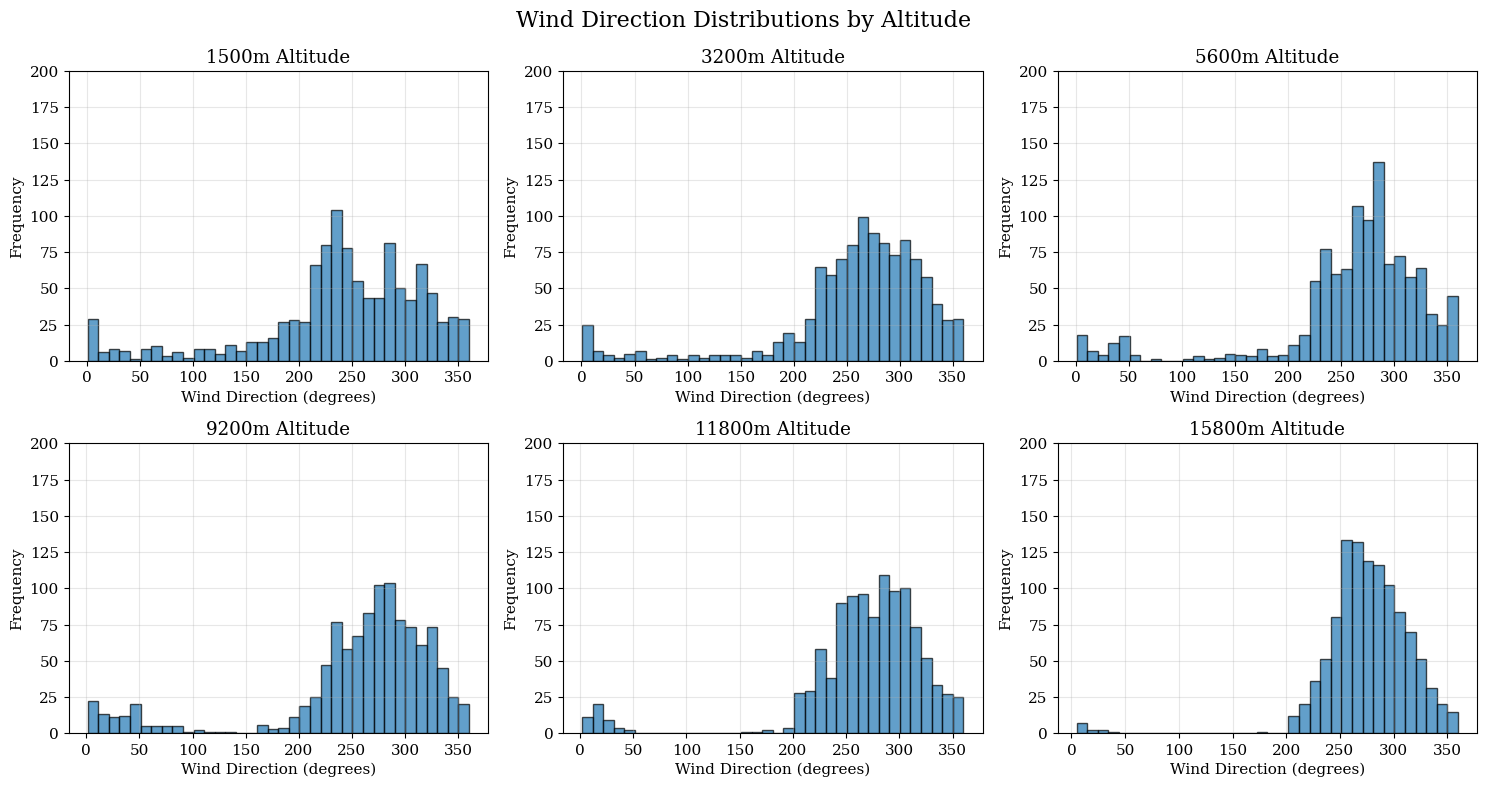

In [131]:
# Distribution of wind directions at different altitudes

altitudes = [1500, 3200, 5600, 9200, 11800, 15800]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, alt in enumerate(altitudes):
    axes[i].hist(df[f'direction [{alt}]'], bins=36, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel('Wind Direction (degrees)')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{alt}m Altitude')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(0, 200)

plt.suptitle('Wind Direction Distributions by Altitude', fontsize=16)
plt.tight_layout()
plt.savefig('plots/wind_direction_distributions_by_altitude.png', dpi=300, bbox_inches='tight')
plt.show()

In [132]:
from astropy.stats import circmean, circstd
from scipy.stats import vonmises
import numpy as np

# Von Mises fitting for wind direction data

altitudes = [1500, 3200, 5600, 9200, 11800, 15800]

for i, alt in enumerate(altitudes):

    directions = df[f'direction [{alt}]'].dropna()

    directions_rad = np.radians(directions)

    # vonmises.fit returns (kappa, loc, scale) but only kappa and loc matters here
    kappa, loc, scale = vonmises.fit(directions_rad, fscale=1)

    mean_direction = np.degrees(loc) % 360

    print(f"Altitude {alt}m:")
    print(f"  Mean direction: {mean_direction:.1f}°")
    print(f"  Kappa (concentration): {kappa:.2f}")
    print(f"  Higher Kappa = more concentrated winds")
    print()

Altitude 1500m:
  Mean direction: 264.0°
  Kappa (concentration): 1.30
  Higher Kappa = more concentrated winds

Altitude 3200m:
  Mean direction: 278.9°
  Kappa (concentration): 1.91
  Higher Kappa = more concentrated winds

Altitude 5600m:
  Mean direction: 283.0°
  Kappa (concentration): 2.08
  Higher Kappa = more concentrated winds

Altitude 9200m:
  Mean direction: 284.5°
  Kappa (concentration): 1.88
  Higher Kappa = more concentrated winds

Altitude 11800m:
  Mean direction: 281.6°
  Kappa (concentration): 2.54
  Higher Kappa = more concentrated winds

Altitude 15800m:
  Mean direction: 279.4°
  Kappa (concentration): 3.58
  Higher Kappa = more concentrated winds



In [133]:
from astropy.stats import rayleightest

# Rayleigh Test for uniformity of wind directions

print("Rayleigh Test for Wind Direction Uniformity")
print()
print("Tests if winds have a preferred direction vs random")
print()

altitudes = [1500, 3200, 5600, 9200, 11800, 15800]

for alt in altitudes:
    directions = df[f'direction [{alt}]'].dropna()
    directions_rad = np.radians(directions)
    
    p_value = rayleightest(directions_rad)
    
    print(f"Altitude {alt}m:")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Result: {'Preferred direction' if p_value < 0.05 else 'Random/Uniform'}")
    print()

Rayleigh Test for Wind Direction Uniformity

Tests if winds have a preferred direction vs random

Altitude 1500m:
  p-value: 0.000000
  Result: Preferred direction

Altitude 3200m:
  p-value: 0.000000
  Result: Preferred direction

Altitude 5600m:
  p-value: 0.000000
  Result: Preferred direction

Altitude 9200m:
  p-value: 0.000000
  Result: Preferred direction

Altitude 11800m:
  p-value: 0.000000
  Result: Preferred direction

Altitude 15800m:
  p-value: 0.000000
  Result: Preferred direction



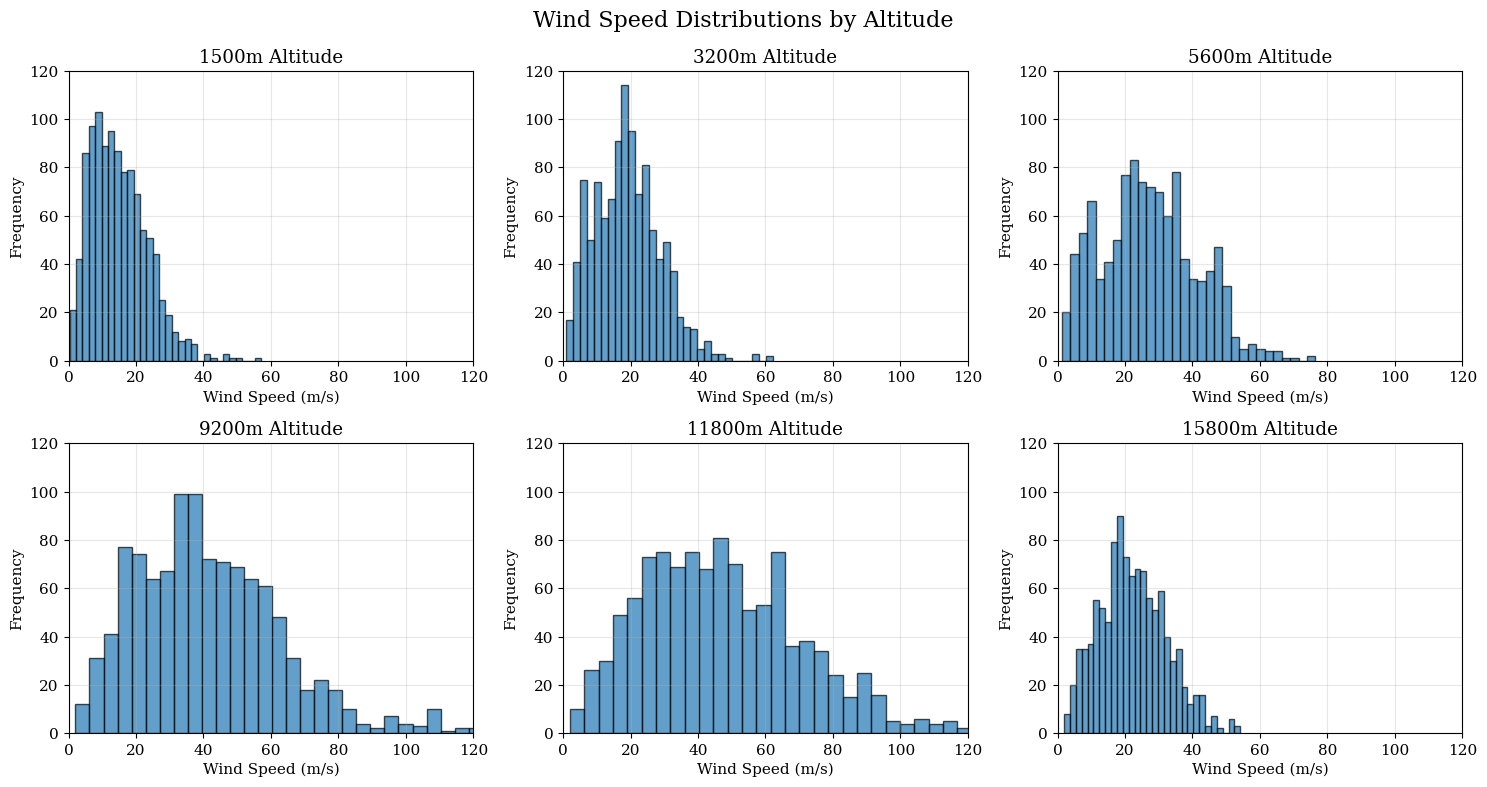

In [134]:
# Distribution of wind speeds at different altitudes

altitudes = [1500, 3200, 5600, 9200, 11800, 15800]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, alt in enumerate(altitudes):
    speeds = df[str(alt)].dropna()
    axes[i].hist(speeds, bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel('Wind Speed (m/s)')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{alt}m Altitude')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xlim(0, 120)
    axes[i].set_ylim(0, 120)

plt.suptitle('Wind Speed Distributions by Altitude', fontsize=16)
plt.tight_layout()
plt.savefig('plots/wind_speed_distributions_by_altitude.png', dpi=300, bbox_inches='tight')
plt.show()

In [135]:
from scipy.stats import weibull_min

# Weibull fitting for wind speed data

altitudes = [1500, 3200, 5600, 9200, 11800, 15800]

for alt in altitudes:
    speeds = df[str(alt)].dropna()
    
    # returns (shape, loc, scale) and we only care about shape and scale
    shape, loc, scale = weibull_min.fit(speeds, floc=0)
    
    print(f"Altitude {alt}m:")
    print(f"  Shape (k): {shape:.2f}")
    print(f"  Scale (λ): {scale:.2f}")
    print(f"  Mean speed: {speeds.mean():.2f} m/s")
    print()

Altitude 1500m:
  Shape (k): 1.85
  Scale (λ): 16.84
  Mean speed: 14.95 m/s

Altitude 3200m:
  Shape (k): 2.07
  Scale (λ): 21.50
  Mean speed: 19.05 m/s

Altitude 5600m:
  Shape (k): 2.01
  Scale (λ): 30.55
  Mean speed: 27.12 m/s

Altitude 9200m:
  Shape (k): 2.02
  Scale (λ): 46.80
  Mean speed: 41.42 m/s

Altitude 11800m:
  Shape (k): 2.07
  Scale (λ): 53.80
  Mean speed: 47.63 m/s

Altitude 15800m:
  Shape (k): 2.39
  Scale (λ): 25.09
  Mean speed: 22.23 m/s



In [136]:
# Kolmogorov-Smirnov test for Weibull fit

from scipy.stats import kstest

print("Weibull Goodness-of-Fit Tests (Wind Speed)")
print()

for alt in altitudes:
    speeds = df[str(alt)].dropna()
    
    shape, loc, scale = weibull_min.fit(speeds, floc=0)
    
    ks_stat, p_value = kstest(speeds, lambda x: weibull_min.cdf(x, shape, loc, scale))
    
    print(f"Altitude {alt}m:")
    print(f"  KS statistic: {ks_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Fit quality: {'GOOD' if p_value > 0.05 else 'POOR'}")
    print()

Weibull Goodness-of-Fit Tests (Wind Speed)

Altitude 1500m:
  KS statistic: 0.0274
  p-value: 0.3806
  Fit quality: GOOD

Altitude 3200m:
  KS statistic: 0.0439
  p-value: 0.0294
  Fit quality: POOR

Altitude 5600m:
  KS statistic: 0.0457
  p-value: 0.0208
  Fit quality: POOR

Altitude 9200m:
  KS statistic: 0.0240
  p-value: 0.5512
  Fit quality: GOOD

Altitude 11800m:
  KS statistic: 0.0144
  p-value: 0.9758
  Fit quality: GOOD

Altitude 15800m:
  KS statistic: 0.0199
  p-value: 0.7750
  Fit quality: GOOD



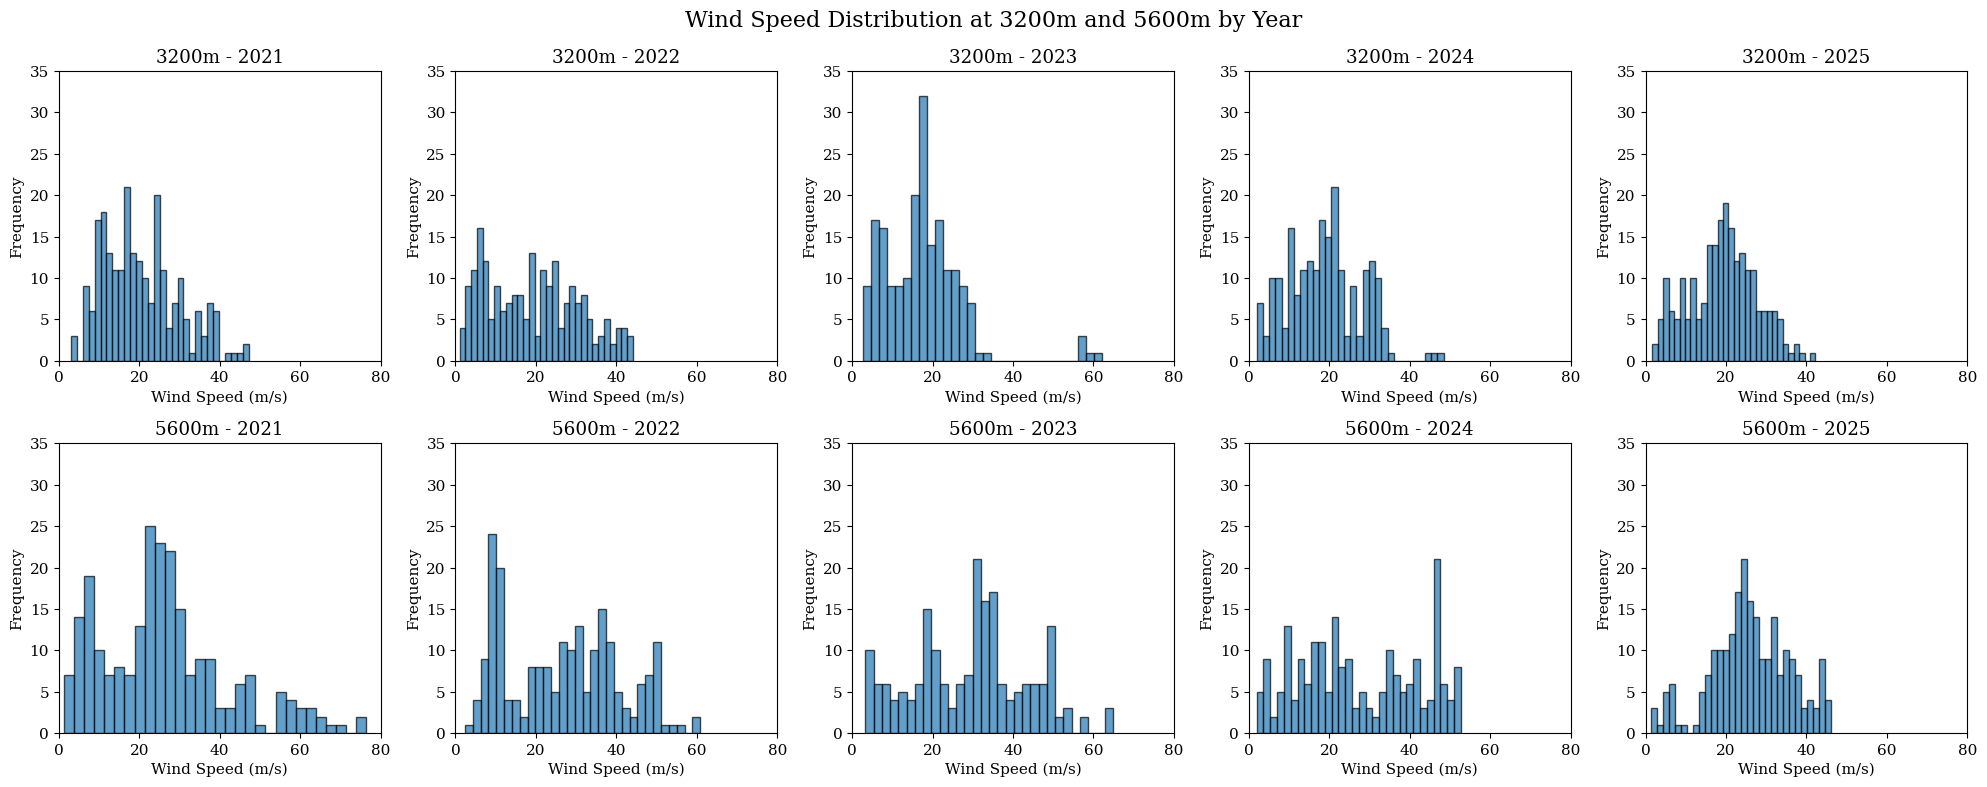

In [141]:
# Analysis of wind speed distribution at 3200m and 5600m, to investigate outlier behaviour

df['year'] = pd.to_datetime(df['date'], format='mixed').dt.year

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, year in enumerate(sorted(df['year'].unique())):
    year_speeds_3200 = df[df['year'] == year][str(3200)].dropna()
    year_speeds_5600 = df[df['year'] == year][str(5600)].dropna()
    axes[0, i].hist(year_speeds_3200, bins=30, edgecolor='black', alpha=0.7)
    axes[0, i].set_xlabel('Wind Speed (m/s)')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].set_title(f'3200m - {year}')
    axes[1, i].hist(year_speeds_5600, bins=30, edgecolor='black', alpha=0.7)
    axes[1, i].set_xlabel('Wind Speed (m/s)')
    axes[1, i].set_ylabel('Frequency')
    axes[1, i].set_title(f'5600m - {year}')
    axes[0, i].set_xlim(0, 80)
    axes[0, i].set_ylim(0, 35)
    axes[1, i].set_xlim(0, 80)
    axes[1, i].set_ylim(0, 35)

plt.suptitle('Wind Speed Distribution at 3200m and 5600m by Year', fontsize=16)
plt.tight_layout()
plt.savefig('plots/wind_speed_distribution_3200_5600_by_year.png', dpi=300, bbox_inches='tight')
plt.show()